In [1]:
import os
os.environ['PYTHONHASHSEED']=str(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)
# the libraries above are used to set seeds for replication purposes


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import split
import math
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from workalendar.europe import Greece
cal = Greece()
# libraries for preprocessing

import tensorflow as tf
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential,Model
from keras.models import load_model
from keras.layers import Dropout
from keras.layers import Input,Dense,LSTM,GRU,RNN
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1
from keras.regularizers import l2
#tensorflow and keras

Using TensorFlow backend.


At this case we are going to build LSTM models for forecasting using a sliding window of size 1.

In [2]:
data=pd.read_excel('all_data.xlsx')
print(data.shape)
validation_set=data.tail(5376)
data=data.head(21648) # This should be divisible by the input shape e.g. 21648/48 
data

(27024, 8)


,Date,Load,Temperature_Athens,Wind_Athens,Humidity_Athens,Temperature_Thessaloniki,Wind_Thessaloniki,Humidity_Thessaloniki
0,2018-06-01 00:00:00,5047,21.5,2.5,30.0,19.0,1.0,66.0
1,2018-06-01 01:00:00,4696,20.0,2.0,33.0,19.0,1.0,68.0
2,2018-06-01 02:00:00,4560,19.0,2.0,36.0,19.0,1.0,64.0
3,2018-06-01 03:00:00,4482,21.0,2.5,32.0,17.0,1.5,73.0
4,2018-06-01 04:00:00,4465,20.5,1.0,34.0,16.5,1.5,75.0
...,...,...,...,...,...,...,...,...
21643,2020-11-18 19:00:00,6483,15.0,2.0,72.0,12.5,1.0,82.0
21644,2020-11-18 20:00:00,6339,14.5,2.5,74.5,12.5,1.5,79.5
21645,2020-11-18 21:00:00,5991,14.0,2.0,74.5,13.0,1.0,82.0
21646,2020-11-18 22:00:00,5396,14.0,3.0,74.5,13.5,1.0,77.0


In [3]:
def working_days(df_date):
    if cal.is_working_day(df_date):
        return 1
    else:
        return 0
    
data.index=data.Date
data['Month'] = data.index.month
data['Holiday_weekend']=data['Date'].apply(working_days)
data=data.reset_index(drop=True)
data

,Date,Load,Temperature_Athens,Wind_Athens,Humidity_Athens,Temperature_Thessaloniki,Wind_Thessaloniki,Humidity_Thessaloniki,Month,Holiday_weekend
0,2018-06-01 00:00:00,5047,21.5,2.5,30.0,19.0,1.0,66.0,6,1
1,2018-06-01 01:00:00,4696,20.0,2.0,33.0,19.0,1.0,68.0,6,1
2,2018-06-01 02:00:00,4560,19.0,2.0,36.0,19.0,1.0,64.0,6,1
3,2018-06-01 03:00:00,4482,21.0,2.5,32.0,17.0,1.5,73.0,6,1
4,2018-06-01 04:00:00,4465,20.5,1.0,34.0,16.5,1.5,75.0,6,1
...,...,...,...,...,...,...,...,...,...,...
21643,2020-11-18 19:00:00,6483,15.0,2.0,72.0,12.5,1.0,82.0,11,1
21644,2020-11-18 20:00:00,6339,14.5,2.5,74.5,12.5,1.5,79.5,11,1
21645,2020-11-18 21:00:00,5991,14.0,2.0,74.5,13.0,1.0,82.0,11,1
21646,2020-11-18 22:00:00,5396,14.0,3.0,74.5,13.5,1.0,77.0,11,1


In [4]:
input_data=data[['Load','Month','Temperature_Athens','Wind_Athens','Humidity_Athens',
                'Temperature_Thessaloniki','Wind_Thessaloniki','Humidity_Thessaloniki']]
output_data=data['Load']

input_scaler=MinMaxScaler() # scale all input data to [0,1] range
input_scaled=input_scaler.fit_transform(input_data)
input_scaled=pd.DataFrame(input_scaled)
input_scaled['Holiday_weekend']=data['Holiday_weekend']
input_scaled.columns=['Load','Month','Temperature_Athens','Wind_Athens','Humidity_Athens',
                'Temperature_Thessaloniki','Wind_Thessaloniki','Humidity_Thessaloniki','Holiday_weekend']


output_scaler=MinMaxScaler() # scale the output load to [0,1] range as well
output_scaled=output_scaler.fit_transform(np.array(output_data).reshape(-1,1))
output_scaled=pd.DataFrame(output_scaled)
output_scaled.columns=['Load']

filename1 = 'input_scaler_v2.sav' # save the fitted scalers in a file
filename2 = 'output_scaler_v2.sav'
pickle.dump(input_scaler, open(filename1, 'wb'))
pickle.dump(output_scaler, open(filename2, 'wb'))

C:\Users\Manos\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Manos\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


At this run, we are using 48 past hours as our input shape, so as to predict 24h ahead.

In [5]:
load_array=np.array(input_scaled['Load'])
load_array=np.array(split(load_array, len(load_array)/48))

month_array=np.array(input_scaled['Month'])
month_array=np.array(split(month_array, len(month_array)/48))

temp_array1=np.array(input_scaled['Temperature_Athens'])
temp_array1=np.array(split(temp_array1, len(temp_array1)/48))

wind_array1=np.array(input_scaled['Wind_Athens'])
wind_array1=np.array(split(wind_array1, len(wind_array1)/48))

hum_array1=np.array(input_scaled['Humidity_Athens'])
hum_array1=np.array(split(hum_array1, len(hum_array1)/48))

temp_array2=np.array(input_scaled['Temperature_Thessaloniki'])
temp_array2=np.array(split(temp_array2, len(temp_array2)/48))

wind_array2=np.array(input_scaled['Wind_Thessaloniki'])
wind_array2=np.array(split(wind_array2, len(wind_array2)/48))

hum_array2=np.array(input_scaled['Humidity_Thessaloniki'])
hum_array2=np.array(split(hum_array2, len(hum_array2)/48))

hol_array=np.array(input_scaled['Holiday_weekend'])
hol_array=np.array(split(hol_array, len(hol_array)/48))

In [6]:
load_array.shape

(451, 48)

In [7]:
def to_supervised(data,n_input,n_out):
    data = data.reshape((data.shape[0]*data.shape[1], 1)) # reshape to 2d
    x, y = [],[]
    in_start = 0
    for i in range(len(data)): 
        in_end = in_start + n_input # this is the end of the input sequence
        out_end = in_end + n_out
        if out_end <= len(data): # this should always stand
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            x.append(x_input)
            y.append(data[in_end:out_end, 0])
        in_start += 1 # one step forward
    return(np.array(x),np.array(y))

In [8]:
# This is a sliding window of size 1
# use 48h as input to predict the next 24 h. Then 1 new hour goes to input and 1 new hour to output and so on...
x_load,y_load=to_supervised(load_array,48,24)
x_month=to_supervised(month_array,48,24)[0]
x_hol=to_supervised(hol_array,48,24)[0]
x_temp1=to_supervised(temp_array1,48,24)[0]
x_wind1=to_supervised(wind_array1,48,24)[0]
x_hum1=to_supervised(hum_array1,48,24)[0]
x_temp2=to_supervised(temp_array2,48,24)[0]
x_wind2=to_supervised(wind_array2,48,24)[0]
x_hum2=to_supervised(hum_array2,48,24)[0]

In [9]:
# This is just for checking everything works ok
# Compares the transformed arrays for load (x_load, y_load) with the original data we began with (input_scaled)

for i in range(1000):
    load_actual_x = round(input_scaled.head(48+i).iloc[i:].sum()['Load'],5)    
    load_actual_y=round(input_scaled.iloc[48+i:48+i+24].sum()['Load'],5)
    
    # e.g. the first 48 h of the input_scaled df should be the same as x_load[0] (first observation in our transformed array)
    if load_actual_x != round(x_load[i].sum(),5): 
        print(i)
        print(load_actual_x,round(sum(x_load[i][0]),5))
    if load_actual_y!=round(y_load[i].sum(),5):
        print('ERROR!!!')

#

In [10]:
x_values=np.dstack((x_load, x_month, x_hol, x_temp1, x_wind1, x_hum1, x_temp2, x_wind2, x_hum2)) # combine all input arrays along the 3rd dimension
y_values=y_load.copy()

In [11]:
x_values.shape

(21577, 48, 9)

In [12]:
y_values.shape

(21577, 24)

In [13]:
x_train,x_test,y_train,y_test = train_test_split(x_values,y_values,test_size=0.3,random_state=0)

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = Sequential()
model.add(LSTM(100,input_shape=(48, 9),return_sequences=True))
model.add(LSTM(100,return_sequences=False))
# model.add(Dropout(0.2))
model.add(Dense(24,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 48, 100)           44000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 24)                2424      
Total params: 126,824
Trainable params: 126,824
Non-trainable params: 0
_________________________________________________________________


Train on 12082 samples, validate on 3021 samples
Epoch 1/1000
12082/12082 [==============================] - 40s 3ms/step - loss: 0.0261 - mape: 19958.7480 - val_loss: 0.0189 - val_mape: 3554.2695

Epoch 00001: val_loss improved from inf to 0.01890, saving model to sliding_window_size1.h5
Epoch 2/1000
12082/12082 [==============================] - 44s 4ms/step - loss: 0.0144 - mape: 12061.4229 - val_loss: 0.0082 - val_mape: 2533.6431

Epoch 00002: val_loss improved from 0.01890 to 0.00823, saving model to sliding_window_size1.h5
Epoch 3/1000
12082/12082 [==============================] - 40s 3ms/step - loss: 0.0066 - mape: 9683.7881 - val_loss: 0.0054 - val_mape: 1638.7465

Epoch 00003: val_loss improved from 0.00823 to 0.00540, saving model to sliding_window_size1.h5
Epoch 4/1000
12082/12082 [==============================] - 40s 3ms/step - loss: 0.0042 - mape: 7235.2432 - val_loss: 0.0034 - val_mape: 1247.4457

Epoch 00004: val_loss improved from 0.00540 to 0.00337, saving model to s

<AxesSubplot:>

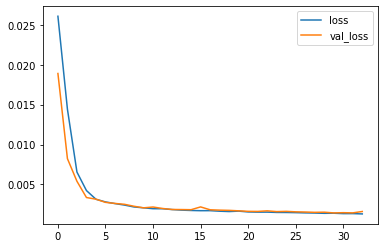

In [15]:
#batch is the number of samples that is shown to the network before a weight update is performed
# 360 here means 360 of our samples. Every new sample contains 1 extra hour.... so 360 batch means 360 new hours (15 days) before weight update

n_epochs = 1000 # don't care much about epochs since we use early stopping
batch=360
model.compile(optimizer='adam', loss='mse', metrics=['mape'])
checkpointer = ModelCheckpoint(filepath="sliding_window_size1.h5",
                               verbose=1,
                               save_best_only=True)

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3) # early stopping

history = model.fit(x_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch,
                    shuffle=True,
                    validation_split=0.20,
                    verbose=1,
                    callbacks=[checkpointer,es_callback])
df_loss = pd.DataFrame(history.history)
df_loss[['loss','val_loss']].plot()

In [16]:
model.save_weights("best_load_model_sliding_window_1_weights")

In [17]:
model = load_model('sliding_window_size1.h5')
input_scaler= pickle.load(open("input_scaler_v2.sav", "rb"))
output_scaler= pickle.load(open("output_scaler_v2.sav", "rb"))
predictions_train = model.predict(x_train)
predictions_test = model.predict(x_test)

predictions_train = output_scaler.inverse_transform(predictions_train)
y_train=output_scaler.inverse_transform(y_train)

predictions_test = output_scaler.inverse_transform(predictions_test)
y_test=output_scaler.inverse_transform(y_test)

trainScore = math.sqrt(mean_squared_error(y_train, predictions_train))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, predictions_test))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 244.68 RMSE
Test Score: 253.17 RMSE


<AxesSubplot:>

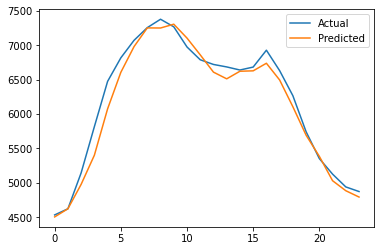

In [18]:
predictions=pd.DataFrame(predictions_test)
predictions['Day']=predictions.index +1
actual=pd.DataFrame(y_test)
actual['Day']=actual.index +1
actual=pd.melt(actual,id_vars=['Day'],var_name='Hour').sort_values(by=['Day','Hour']).reset_index(drop=True)
predicted=pd.melt(predictions,id_vars=['Day'],var_name='Hour').sort_values(by=['Day','Hour']).reset_index(drop=True)


joined=pd.DataFrame()
joined['Actual']=actual['value']
joined['Predicted']=predicted['value']
plot_data=joined[['Actual','Predicted']]

plot_data.head(24).plot()

<AxesSubplot:>

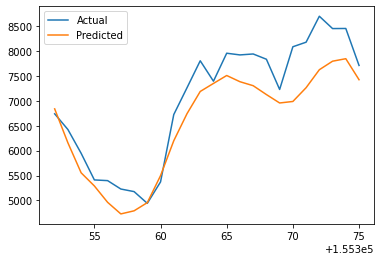

In [19]:
plot_data.tail(24).plot()

<AxesSubplot:>

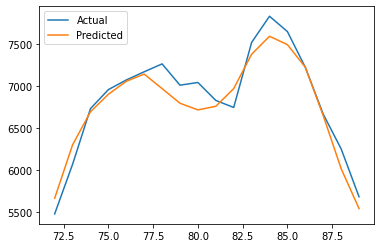

In [20]:
plot_data.iloc[72:90].plot()

<AxesSubplot:>

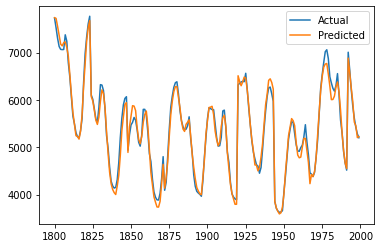

In [21]:
plot_data.iloc[1800:2000].plot()

<AxesSubplot:>

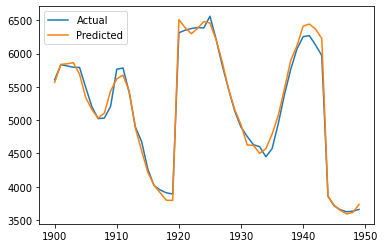

In [22]:
plot_data.iloc[1900:1950].plot()

<AxesSubplot:>

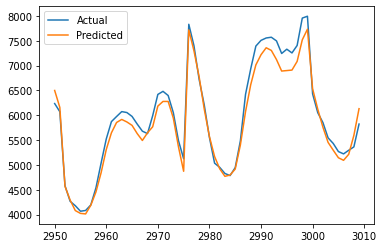

In [23]:
plot_data.iloc[2950:3010].plot()

In [25]:
plot_data['Absolute Percentage Error']=(abs(plot_data['Actual']-plot_data['Predicted'])/plot_data['Actual'])*100
plot_data['Absolute Error']=abs(plot_data['Actual']-plot_data['Predicted'])
plot_data['Residual']=plot_data['Actual']-plot_data['Predicted']
plot_data

,Actual,Predicted,Absolute Percentage Error,Absolute Error,Residual
0,4533.0,4504.063477,0.638353,28.936523,28.936523
1,4622.0,4622.335449,0.007258,0.335449,-0.335449
2,5144.0,4977.289551,3.240872,166.710449,166.710449
3,5816.0,5400.733398,7.140072,415.266602,415.266602
4,6474.0,6074.889648,6.164819,399.110352,399.110352
...,...,...,...,...,...
155371,8182.0,7266.402832,11.190383,915.597168,915.597168
155372,8704.0,7627.876465,12.363552,1076.123535,1076.123535
155373,8456.0,7799.650391,7.761940,656.349609,656.349609
155374,8458.0,7849.792969,7.190908,608.207031,608.207031


In [26]:
plot_data['Absolute Percentage Error'].mean()

3.2163510245718485

In [27]:
plot_data['Absolute Error'].mean()

184.47642509233398

<AxesSubplot:>

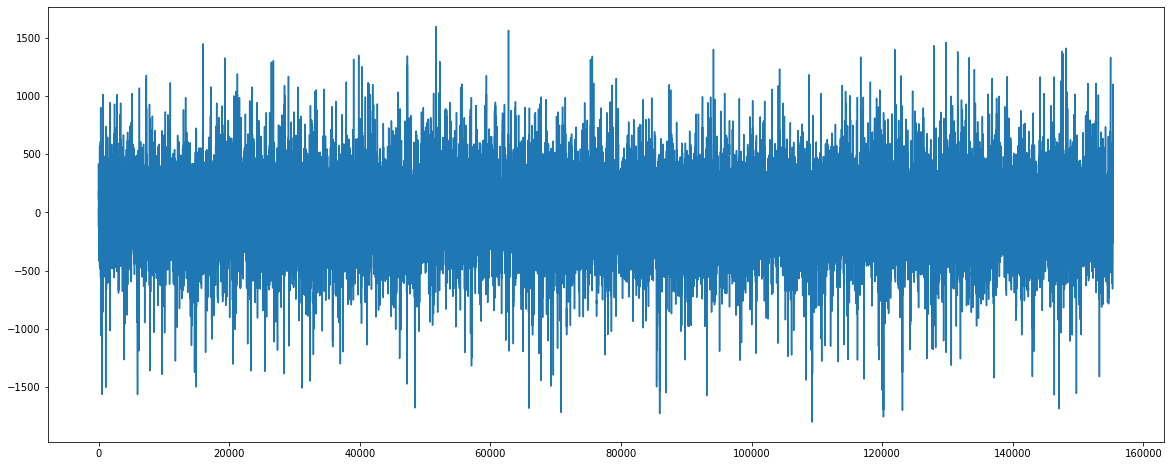

In [28]:
plot_data['Residual'].plot(figsize=(20,8))

<AxesSubplot:>

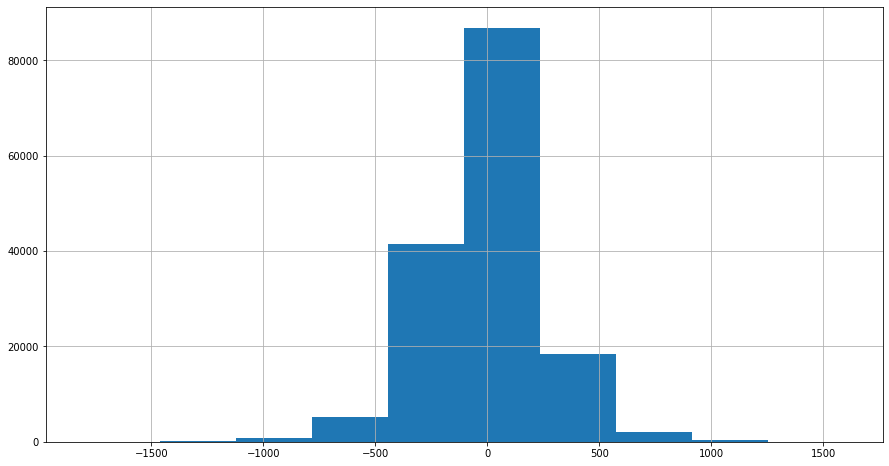

In [29]:
plot_data['Residual'].hist(figsize=(15,8))

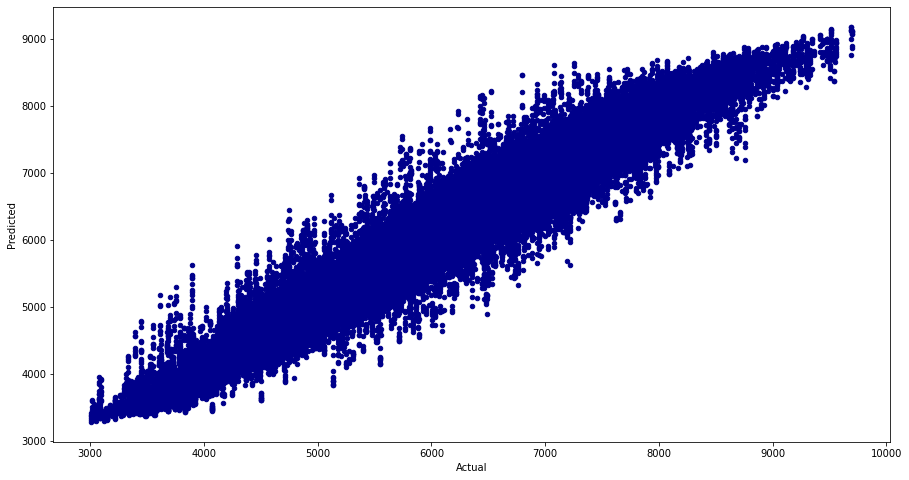

In [30]:
ax1 = plot_data.plot.scatter(x='Actual',
                      y='Predicted',
                      c='DarkBlue', figsize=(15,8))

# Try model on different training and test sets

In [31]:
input_data=data[['Load','Month','Temperature_Athens','Wind_Athens','Humidity_Athens',
                'Temperature_Thessaloniki','Wind_Thessaloniki','Humidity_Thessaloniki']]
output_data=data['Load']
input_scaler=MinMaxScaler() # scale all input data to [0,1] range
input_scaled=input_scaler.fit_transform(input_data)
input_scaled=pd.DataFrame(input_scaled)
input_scaled['Holiday_weekend']=data['Holiday_weekend']
input_scaled.columns=['Load','Month','Temperature_Athens','Wind_Athens','Humidity_Athens',
                'Temperature_Thessaloniki','Wind_Thessaloniki','Humidity_Thessaloniki','Holiday_weekend']
output_scaler=MinMaxScaler() # scale the output load to [0,1] range as well
output_scaled=output_scaler.fit_transform(np.array(output_data).reshape(-1,1))
output_scaled=pd.DataFrame(output_scaled)
output_scaled.columns=['Load']
filename1 = 'input_scaler_v2.sav' # save the fitted scalers in a file
filename2 = 'output_scaler_v2.sav'
pickle.dump(input_scaler, open(filename1, 'wb'))
pickle.dump(output_scaler, open(filename2, 'wb'))


load_array=np.array(input_scaled['Load'])
load_array=np.array(split(load_array, len(load_array)/48))
month_array=np.array(input_scaled['Month'])
month_array=np.array(split(month_array, len(month_array)/48))
temp_array1=np.array(input_scaled['Temperature_Athens'])
temp_array1=np.array(split(temp_array1, len(temp_array1)/48))
wind_array1=np.array(input_scaled['Wind_Athens'])
wind_array1=np.array(split(wind_array1, len(wind_array1)/48))
hum_array1=np.array(input_scaled['Humidity_Athens'])
hum_array1=np.array(split(hum_array1, len(hum_array1)/48))
temp_array2=np.array(input_scaled['Temperature_Thessaloniki'])
temp_array2=np.array(split(temp_array2, len(temp_array2)/48))
wind_array2=np.array(input_scaled['Wind_Thessaloniki'])
wind_array2=np.array(split(wind_array2, len(wind_array2)/48))
hum_array2=np.array(input_scaled['Humidity_Thessaloniki'])
hum_array2=np.array(split(hum_array2, len(hum_array2)/48))
hol_array=np.array(input_scaled['Holiday_weekend'])
hol_array=np.array(split(hol_array, len(hol_array)/48))


x_load,y_load=to_supervised(load_array,48,24)
x_month=to_supervised(month_array,48,24)[0]
x_hol=to_supervised(hol_array,48,24)[0]
x_temp1=to_supervised(temp_array1,48,24)[0]
x_wind1=to_supervised(wind_array1,48,24)[0]
x_hum1=to_supervised(hum_array1,48,24)[0]
x_temp2=to_supervised(temp_array2,48,24)[0]
x_wind2=to_supervised(wind_array2,48,24)[0]
x_hum2=to_supervised(hum_array2,48,24)[0]

x_values=np.dstack((x_load, x_month, x_hol, x_temp1, x_wind1, x_hum1, x_temp2, x_wind2, x_hum2)) # combine all input arrays along the 3rd dimension
y_values=y_load.copy()

C:\Users\Manos\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Manos\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [33]:
################### Train & Test Split ###########################################

temp_train_scores=[]
temp_test_scores=[]
finish_point=0

while finish_point < 5: # try 5 different train test splits and average results from all splits
    
    x_train,x_test,y_train,y_test = train_test_split(x_values,y_values,test_size=0.3,random_state=finish_point)
    
#################### Build Model #################################################
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    model = Sequential()
    model.add(LSTM(100,input_shape=(48, 9),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100,return_sequences=False))
    model.add(Dense(24,activation='sigmoid'))

    n_epochs = 1000 
    batch=360
    model.compile(optimizer='adam', loss='mse')
    checkpointer = ModelCheckpoint(filepath="load_model.h5",
                                   verbose=0,
                                   save_best_only=True)
    es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3) # early stopping
    history = model.fit(x_train, y_train,
                        epochs=n_epochs,
                        batch_size=batch,
                        shuffle=True,
                        validation_split=0.20,
                        verbose=0,
                        callbacks=[checkpointer,es_callback])

################# load trained model and make predictions ################################
    model = load_model('load_model.h5')
    input_scaler= pickle.load(open("input_scaler.sav", "rb"))
    output_scaler= pickle.load(open("output_scaler.sav", "rb"))
    predictions_train = model.predict(x_train)
    predictions_test = model.predict(x_test)

    predictions_train = output_scaler.inverse_transform(predictions_train)
    y_train=output_scaler.inverse_transform(y_train)

    predictions_test = output_scaler.inverse_transform(predictions_test)
    y_test=output_scaler.inverse_transform(y_test)

    trainScore = math.sqrt(mean_squared_error(y_train, predictions_train))
    testScore = math.sqrt(mean_squared_error(y_test, predictions_test))
    temp_train_scores.append(trainScore)
    temp_test_scores.append(testScore)
    
    finish_point += 1

print('Train Score: %.2f RMSE' % (sum(temp_train_scores)/len(temp_train_scores)))
print('Test Score: %.2f RMSE' % (sum(temp_test_scores)/len(temp_test_scores)))
(sum(temp_train_scores)/len(temp_train_scores),sum(temp_test_scores)/len(temp_test_scores))

Train Score: 227.42 RMSE
Test Score: 234.36 RMSE


SyntaxError: 'return' outside function (<ipython-input-33-c72651e128ac>, line 58)

In [34]:
(sum(temp_train_scores)/len(temp_train_scores),sum(temp_test_scores)/len(temp_test_scores))

(227.42247159287513, 234.36272151264393)